In [0]:
# Import dependencies
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

In [2]:
# Download data

!mkdir malaria
!ls

malaria  sample_data


In [0]:
# Download Malaria Dataset from official NIH webpage
os.chdir('malaria')
!wget https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip
!unzip cell_images.zip

In [4]:
# Examine directory structure  

!sudo apt-get install tree
os.chdir('/content')
!tree --dirsfirst --filelimit 10

/bin/bash: tree: command not found


In [0]:
ORIG_INPUT_DATASET = 'malaria/cell_images'
BASE_PATH = 'malaria'

TRAIN_PATH = os.path.sep.join([BASE_PATH, "training"])
VAL_PATH = os.path.sep.join([BASE_PATH, "validation"])
TEST_PATH = os.path.sep.join([BASE_PATH, "testing"])

TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1

In [6]:
print('Number of Parasitized images: ', len(os.listdir('malaria/cell_images/Parasitized')))
print('Number of Uninfected images: ', len(os.listdir('malaria/cell_images/Uninfected')))

Number of Parasitized images:  13780
Number of Uninfected images:  13780


In [0]:
!mkdir malaria/training
!mkdir malaria/validation
!mkdir malaria/testing


!mkdir malaria/training/Parasitized
!mkdir malaria/training/Uninfected
!mkdir malaria/validation/Parasitized
!mkdir malaria/validation/Uninfected
!mkdir malaria/testing/Parasitized
!mkdir malaria/testing/Uninfected

In [0]:
import random

def move_files(source_dir, target_dir, num_files):
  for i in range(int(num_files)):
    file_count = len(os.listdir(source_dir)) - 1
    file =  os.listdir(source_dir)[random.randint(0, file_count)]
    os.rename(os.path.join(source_dir, file), os.path.join(target_dir, file))

In [0]:
# move 80% files from base directory to training folder
move_files('malaria/cell_images/Parasitized', 'malaria/training/Parasitized', TRAIN_SPLIT * len(os.listdir('malaria/cell_images/Parasitized')))
move_files('malaria/cell_images/Uninfected', 'malaria/training/Uninfected', TRAIN_SPLIT * len(os.listdir('malaria/cell_images/Uninfected')))

In [0]:
# move 10% files from training directory to validation folder
move_files('malaria/training/Parasitized','malaria/validation/Parasitized', VAL_SPLIT * len(os.listdir('malaria/training/Parasitized')))
move_files('malaria/training/Uninfected','malaria/validation/Uninfected', VAL_SPLIT * len(os.listdir('malaria/training/Uninfected')))

In [0]:
# move rest of the files from base directory to testing folder
move_files('malaria/cell_images/Parasitized','malaria/testing/Parasitized',  len(os.listdir('malaria/cell_images/Parasitized')))
move_files('malaria/cell_images/Uninfected','malaria/testing/Uninfected',  len(os.listdir('malaria/cell_images/Uninfected')))

In [12]:
print('Parasitized folders')
print('----------------------------------')
print('#files in training folder: ', len(os.listdir('malaria/training/Parasitized')))
print('#files in testing folder: ', len(os.listdir('malaria/testing/Parasitized')))
print('#files in validation folder: ', len(os.listdir('malaria/validation/Parasitized')))

print('Uninfected folders')
print('----------------------------------')
print('#files in training folder: ', len(os.listdir('malaria/training/Uninfected')))
print('#files in testing folder: ', len(os.listdir('malaria/testing/Uninfected')))
print('#files in validation folder: ', len(os.listdir('malaria/validation/Uninfected')))

print('----------------------------------')

#files in training folder:  9922
#files in testing folder:  2756
#files in validation folder:  1102
#files in training folder:  9922
#files in testing folder:  2756
#files in validation folder:  1102
#files in base folder:  0
#files in base folder:  0


In [0]:
# Import the InceptionV3 model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the ResNet50 model 
pre_trained_model = InceptionV3(input_shape = (125, 125, 3), include_top = False, weights = 'imagenet')

# Make some of the layers in the pre-trained model non-trainable for fine tuning

for layer in pre_trained_model.layers:
  if layer.name in ['conv2d_93', 'batch_normalization_85', 'activation_87', 'activation_88', 'activation_91', 'activation_92',
'batch_normalization_93', 'activation_85', 'mixed9_1', 'concatenate_1', 'activation_93', 'mixed10']:
    layer.trainable = True
  else:
    layer.trainable = False
  
  
last_output = pre_trained_model.output

In [26]:
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
# Define the architecture

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.3
x = layers.Dropout(0.3)(x)  
# Add another fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# # Add a dropout rate of 0.3
x = layers.Dropout(0.3)(x)  
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x) 

model.compile(optimizer = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True), loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 125, 125, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 62, 62, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 62, 62, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 62, 62, 32)   0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = 'malaria/training'
validation_dir = 'malaria/validation'
testing_dir = 'malaria/testing'

# Add data augmentation to ImageDataGenerator - only for training
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=25, width_shift_range=0.05,height_shift_range=0.05, 
                                   shear_range=0.05, zoom_range=0.05, horizontal_flip=True, fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Feed images to the Generator
train_generator = train_datagen.flow_from_directory(train_dir, batch_size=64, class_mode='binary', target_size=(125,125))
validation_generator = validation_datagen.flow_from_directory(validation_dir, batch_size=64, class_mode='binary', target_size=(125,125))
test_generator = test_datagen.flow_from_directory(testing_dir, batch_size=64, class_mode='binary', target_size=(125,125))

Found 19842 images belonging to 2 classes.
Found 2204 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


In [27]:
history = model.fit_generator(
          train_generator,
          validation_data = validation_generator,
          steps_per_epoch = 128,
          epochs = 20,
          validation_steps = 32,
          verbose = 2)

Epoch 1/20
128/128 - 49s - loss: 0.5943 - acc: 0.6802 - val_loss: 0.4222 - val_acc: 0.8242
Epoch 2/20
128/128 - 43s - loss: 0.4620 - acc: 0.7933 - val_loss: 0.4327 - val_acc: 0.8145
Epoch 3/20
128/128 - 43s - loss: 0.4272 - acc: 0.8161 - val_loss: 0.4153 - val_acc: 0.8408
Epoch 4/20
128/128 - 43s - loss: 0.4112 - acc: 0.8217 - val_loss: 0.3901 - val_acc: 0.8579
Epoch 5/20
128/128 - 43s - loss: 0.3844 - acc: 0.8327 - val_loss: 0.4083 - val_acc: 0.8647
Epoch 6/20
128/128 - 44s - loss: 0.3738 - acc: 0.8374 - val_loss: 0.4131 - val_acc: 0.8457
Epoch 7/20
128/128 - 43s - loss: 0.3860 - acc: 0.8433 - val_loss: 0.3874 - val_acc: 0.8599
Epoch 8/20
128/128 - 43s - loss: 0.3648 - acc: 0.8488 - val_loss: 0.4407 - val_acc: 0.8330
Epoch 9/20
128/128 - 43s - loss: 0.3608 - acc: 0.8458 - val_loss: 0.4266 - val_acc: 0.8486
Epoch 10/20
128/128 - 43s - loss: 0.3575 - acc: 0.8486 - val_loss: 0.4626 - val_acc: 0.8232
Epoch 11/20
128/128 - 44s - loss: 0.3694 - acc: 0.8431 - val_loss: 0.4050 - val_acc: 0.86

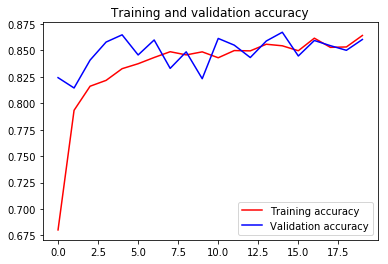

<Figure size 432x288 with 0 Axes>

In [28]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

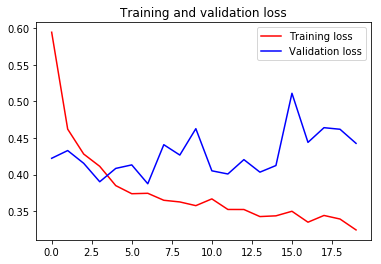

<Figure size 432x288 with 0 Axes>

In [29]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

**VGG Model with fine tuning**

In [30]:
from tensorflow.keras.applications.vgg19 import VGG19

vgg = VGG19(input_shape = (125, 125, 3), include_top = False, weights = 'imagenet')

for layer in vgg.layers:
  if layer.name in ['block5_conv1', 'block4_conv1']:
    layer.trainable = True
  else:
    layer.trainable = False

last_output = vgg.output

80142336/80134624 [==============================] - 7s 0us/step


In [31]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.3
x = layers.Dropout(0.3)(x)  
# Add another fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# # Add a dropout rate of 0.3
x = layers.Dropout(0.3)(x)  
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model(vgg.input, x) 

model.compile(optimizer = RMSprop(lr=1e-5), loss = 'binary_crossentropy', metrics = ['accuracy'])

model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 125, 125, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 125, 125, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 125, 125, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 62, 62, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 62, 62, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 62, 62, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 31, 31, 128)       0   

In [32]:
history = model.fit_generator(
          train_generator,
          validation_data = validation_generator,
          steps_per_epoch = 128,
          epochs = 25,
          validation_steps = 32,
          verbose = 2)

Epoch 1/25
128/128 - 60s - loss: 0.4573 - acc: 0.7678 - val_loss: 0.2440 - val_acc: 0.9033
Epoch 2/25
128/128 - 53s - loss: 0.2294 - acc: 0.9138 - val_loss: 0.1885 - val_acc: 0.9360
Epoch 3/25
128/128 - 53s - loss: 0.1978 - acc: 0.9335 - val_loss: 0.1621 - val_acc: 0.9502
Epoch 4/25
128/128 - 53s - loss: 0.1677 - acc: 0.9426 - val_loss: 0.1504 - val_acc: 0.9502
Epoch 5/25
128/128 - 52s - loss: 0.1531 - acc: 0.9487 - val_loss: 0.1563 - val_acc: 0.9458
Epoch 6/25
128/128 - 53s - loss: 0.1501 - acc: 0.9474 - val_loss: 0.1385 - val_acc: 0.9531
Epoch 7/25
128/128 - 52s - loss: 0.1467 - acc: 0.9503 - val_loss: 0.1357 - val_acc: 0.9561
Epoch 8/25
128/128 - 52s - loss: 0.1400 - acc: 0.9530 - val_loss: 0.1307 - val_acc: 0.9585
Epoch 9/25
128/128 - 52s - loss: 0.1412 - acc: 0.9526 - val_loss: 0.1295 - val_acc: 0.9580
Epoch 10/25
128/128 - 52s - loss: 0.1304 - acc: 0.9528 - val_loss: 0.1328 - val_acc: 0.9575
Epoch 11/25
128/128 - 53s - loss: 0.1299 - acc: 0.9557 - val_loss: 0.1311 - val_acc: 0.95

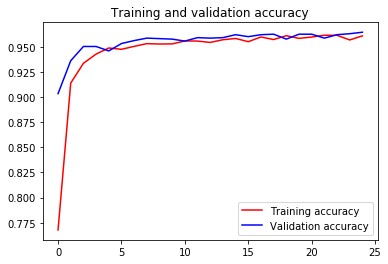

<Figure size 432x288 with 0 Axes>

In [33]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

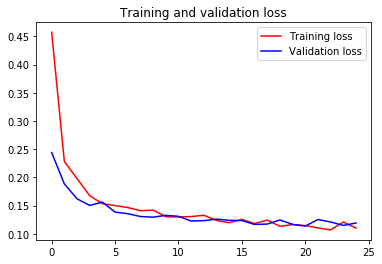

<Figure size 432x288 with 0 Axes>

In [34]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [0]:
# Save the model
model.save('vgg_finetuned.h5')

**Model Performance Evaluation**

In [36]:
# Load saved model
vgg_model = tf.keras.models.load_model('./vgg_finetuned.h5')

W0712 07:47:17.548926 140328886515584 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0712 07:47:17.551190 140328886515584 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [38]:
loss, accuracy = model.evaluate_generator(test_generator, steps=128)

print('Accuracy on Test Set: ', accuracy*100)

Accuracy on Test Set:  96.61996364593506
